# Chest X-Ray Images (Pneumonia) Classification

### Introduction
By Ziv Ben Zvi 203966643 and Julian Rubinstein 204907901.

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.
Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.

As mentioned above, a chest X-ray is a prominent and common way to identify pneumonia. Therefore, developing an accurate model for analyzing the results of a chest X-ray can be extremly helpful in succesfuly diagnosing pneumonia in patients. The following paper will discuss the development of such model and its subsuquent accuracy and efficacy in acomplishing this task. The learning proccess of this model uses the dataset provided in the kaggle competition [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/discussion) and will attempt to classify X-ray lung images to either normal or pneumonia. The dataset contains 5,863 chest X-Ray RGB images (JPEG) divided into NORMAL or PNEUMONIA folders.

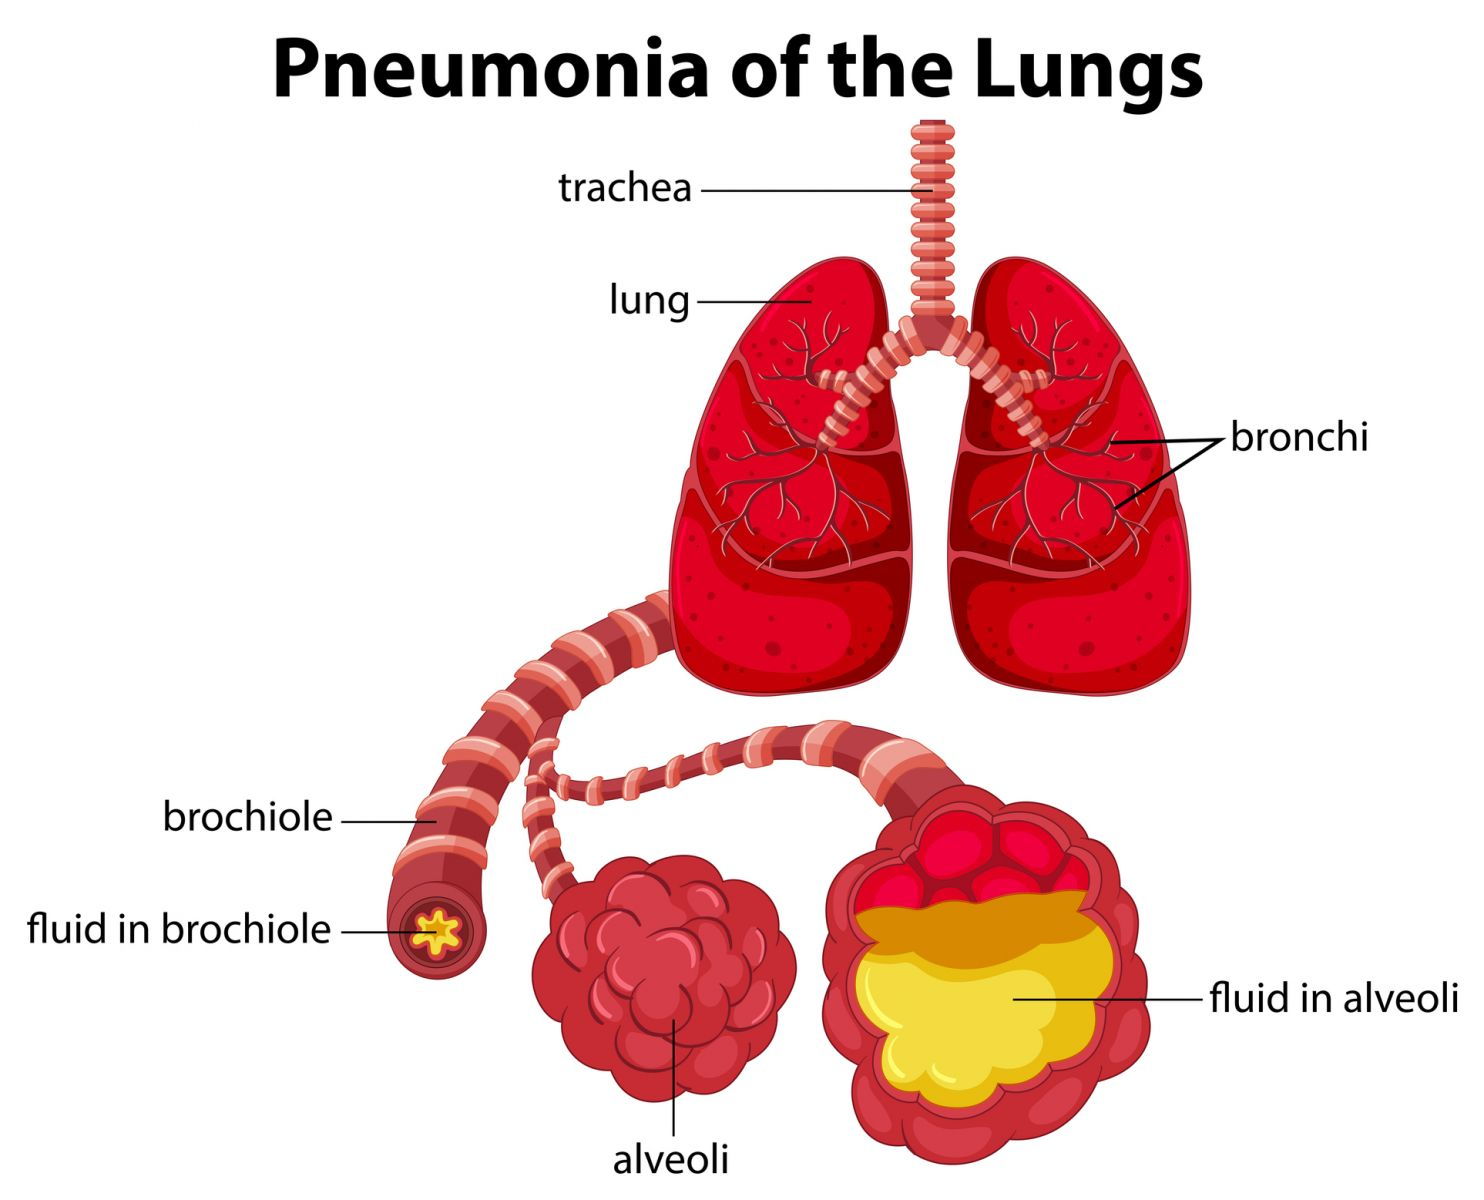

### Imports

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import cv2

In [64]:
import sklearn
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import shap

### Loading Data and Data Processing

We define the data paths, compress the images by resizing them and then load the data to a list of 2d np arrays which represnt the images:

In [3]:
#NORMAL_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/NORMAL'
#PNEUMONIA_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/PNEUMONIA'
NORMAL_PATH = 'chest_xray/DATA/NORMAL'
PNEUMONIA_PATH = 'chest_xray/DATA/PNEUMONIA'

DATA_NUM=1000

NORMAL_FILES = glob(NORMAL_PATH + "/*.jpeg")
PNEUMONIA_FILES = glob(PNEUMONIA_PATH + "/*.jpeg")

normal_data = []
pneumonia_data = []

for file in tqdm(NORMAL_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    normal_data.append(image)

for file in tqdm(PNEUMONIA_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    pneumonia_data.append(image)

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/4265 [00:00<?, ?it/s]

## create copy of the data in order to reset it later if needed

In [7]:
temp_normal_data = normal_data
temp_pneumonia_data = pneumonia_data

Let's print the size of both datasets and the shapes of the images:

In [7]:
print("Number of healthy patients images: " + str(len(normal_data)))
print("Number of sick patients images: " + str(len(pneumonia_data)))
print("Healthy image 1 shape: " + str(normal_data[0].shape))
print("Sick image 1 shape: " + str(pneumonia_data[0].shape))

Number of healthy patients images: 1575
Number of sick patients images: 4265
Healthy image 1 shape: (60, 100, 3)
Sick image 1 shape: (60, 100, 3)


Two things can be observed - Firstly, the shape of the images is 60X100X3, as expected following the compression done above and the fact the images are all RGB images. Secondly, we can see that the data contains approximatly 3 times the amount of sick images to healthy images, that is something that should be taken note of as it can affect the training of the model.

Next, in observing the images, it can be noticed that although the images are in RGB format, all the colors appear to be entirely greyscaled. In the following blocks of code we will check the possibility of converting the images to greyscale to both reduce the file-size of the images (which will make the model training faster) and to reduce the complexity of the images which will ease the process of image analysis.

Firstly, lets observe an image before and after converting it to greyscale format:

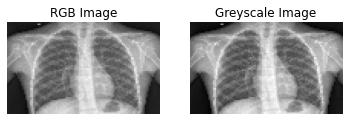

In [8]:
normal_image = normal_data[0]
gray_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,2)

ax[0].imshow(normal_image)
ax[0].set_title('RGB Image')
ax[0].axis('off')

ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title('Greyscale Image')
ax[1].axis('off')

plt.show()

In [10]:
print("Before conversion shape: " + str(normal_data[0].shape))
print("After conversion shape: " + str(gray_image.shape))

Before conversion shape: (60, 100, 3)
After conversion shape: (60, 100)


As expected, it can be clearly seen that the conversion to grayscale hardly affects the visual of the image, if at all. As such, we will proceed to convert all images to grayscale format:

In [4]:
for index, image in enumerate(normal_data):
    normal_data[index] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
for index, image in enumerate(pneumonia_data):
    pneumonia_data[index] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### EDA

As a first step, lets simply observe a number of images of healthy patients and sick patients to see if we can point out any visual difference.

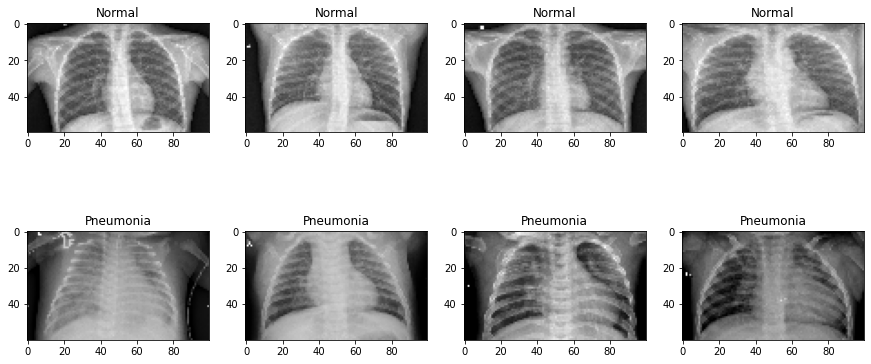

In [12]:
plt.rcParams["figure.figsize"] = (15,7)
fig, axis = plt.subplots(2,4)


for index, image in enumerate(normal_data[:4]):
    axis[0,index].imshow(image, cmap="gray")
    axis[0,index].set_title('Normal')
    
    
for index, image in enumerate(pneumonia_data[:4]):
    axis[1,index].imshow(image, cmap="gray")
    axis[1,index].set_title('Pneumonia')

    
plt.show()

By first examination, a slight difference of opacity within the ribcage can be noticed between the normal and the pneumonia-induced images. The pneumonia images appear to have a more cloudy color as opposed to the more transparent normal images (especially in the bottom left image that can be seen above).

Since these images are already converted to grey-scale, we can observe the single color distribution of the images and the mean pixel values:

<AxesSubplot:title={'center':'pneumonia'}, ylabel='Count'>

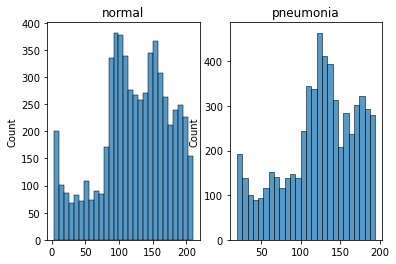

In [5]:
normal_dist = 0
normal_flattened = []

for image in normal_data:
    normal_flattened.append(image.flatten())

for image in normal_flattened:
    normal_dist += image/len(normal_data)

pneumonia_dist = 0
pneumonia_flattened = []

for image in pneumonia_data:
    pneumonia_flattened.append(image.flatten())

for image in pneumonia_flattened:
    pneumonia_dist += image/len(pneumonia_data)

plt.subplot(1, 2, 1)
plt.title('normal')
sns.histplot(normal_dist)

plt.subplot(1, 2, 2)
plt.title('pneumonia')
sns.histplot(pneumonia_dist)

A slight difference of shape between the distributions can be seen, however, nothing clear enough that can be pointed out without the use of more advanced tools. Lets observe the mean and median pixel values:

In [11]:

print(f"The mean pixel value of NORMAL images: {int(np.mean(normal_data))}")
print(f"The mean pixel value of PNEUMONIA images: {int(np.mean(pneumonia_data))}")

print(f"\nThe median pixel value of NORMAL images: {int(np.median(normal_data))}")
print(f"The median pixel value of PNEUMONIA images: {int(np.median(pneumonia_data))}")

print(f"\nThe standard deviation of the pixel value of NORMAL images: {int(np.std(normal_data))}")
print(f"The standard deviation of the pixel value of PNEUMONIA images: {int(np.std(pneumonia_data))}")

The mean pixel value of NORMAL images: 122
The mean pixel value of PNEUMONIA images: 122

The median pixel value of NORMAL images: 132
The median pixel value of PNEUMONIA images: 134

The standard deviation of the pixel value of NORMAL images: 62
The standard deviation of the pixel value of PNEUMONIA images: 59


As can be clearly seen, the mean and median pixel values are extremly close and are well in the standard deviation of the pixel distribution. As such, this is not an avenue that will help the analysis.

### PCA

We will start by defining our pca model and compiling it on our combined dataset of images of both the pneumonia and normal images: 

In [ ]:
combined_pca = sklearn.preprocessing.StandardScaler().fit_transform(normal_flattened + pneumonia_flattened)
pca = sklearn.decomposition.PCA(n_components = 6)
pca.fit(combined_pca)
combined_reduced = pca.transform(combined_pca)
combined_pca_df = pd.DataFrame(data=combined_reduced,columns=['PC1','PC2','PC3','PC4','PC5','PC6'] )
combined_pca_df.head()

In [ ]:
pca.explained_variance_ratio_

df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['PC1','PC2','PC3','PC4','PC5','PC6']})
sns.barplot(x='PC',y="var",data=df, color="c");

print('explained variance ratio (first three components): %s' % str(pca.explained_variance_ratio_[:3]))
print('sum of first three components: %f' % float(sum(pca.explained_variance_ratio_[:3])))

We can see that the first PC contains about a third of the variance in the images while the first three combined hold almost half of all the variance between the images. We will now proceed to divide the images based on their PC scores and see if any of them will show a pattern of normal/pneumonia images. All PCs will be shown with the first 2 rows of images corresponding to the higest score and the second 2 rows will correspond to the low pc score.

#### First PC

In [ ]:
highest_score_ids = np.argpartition(combined_reduced[:, 0], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 0], 8)[:8]

In [ ]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

It can be clearly seen that the first PC is that of the total brightness of the images (the mean value of the pixels of the images). It can be noticed that both the first two rows (lowest score) and the last two rows (highest score) are both entirely made of pneumonia images, as such, this PC does not help our classification.

#### Second PC

In [ ]:
highest_score_ids = np.argpartition(combined_reduced[:, 1], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 1], 8)[:8]

In [ ]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

Similar to the first PC, this PC doesn't help us very much as all rows are consisted of entirely pneumonia images.

#### Third PC

In [ ]:
highest_score_ids = np.argpartition(combined_reduced[:, 2], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 2], 8)[:8]

In [ ]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

Jackpot! This PC has managed to completly divide between the pneumonia images and the normal images with an accuracy of 100% for 16 images. This has to be taken seriously and will be further investigated as a classifcation tool in a few sections.

##### Fourth PC

In [ ]:
highest_score_ids = np.argpartition(combined_reduced[:, 3], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 3], 8)[:8]

In [ ]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

It does'nt look like this PC helps us very much, especially after the results of third pc. The distribution is almost equal between normal and pneumonia images in the first two rows and the last two rows. 

##### Fifth PC

In [ ]:
highest_score_ids = np.argpartition(combined_reduced[:, 4], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 4], 8)[:8]

In [ ]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

Wow! again we managed to find a PC that classifies the images with almost 100% accuracy. This PC will be considered as well as a classification tool for our images. 

##### Sixth PC

In [ ]:
highest_score_ids = np.argpartition(combined_reduced[:, 5], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 5], 8)[:8]

In [ ]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

Similar to the first two PCs, we didn't get much from this PC and we will focus on the PCs that performed the best in classifying our images to normal and pneumonia.

Eventhough we want to believe that our PCs can classify our images according to the results we just had, we can't really know their accuracy before further exploring them.<br> We know that when examining only 16 images for every PC, while the images are being taken from the highest and lowest score of the PC, it's not enough as a classification tool. Especially when we know that among all images of those PC, the more we will check closer to the median scores of the PCs and away from the highest and lowest scores it will be harder to predict the condition accuartly. 

Let's test our real PCs accuracy:

##### Testing the pca  

In [ ]:
def print_pca_group_variation(pca_num):

    ## TOTAL IMAGES -> 5840
    
    normal_count = 0
    pneumonia_count = 0
    NORMAL_LENGTH = len(normal_data) #1575
    PNEUMONIA_LENGTH = len(pneumonia_data) # 4275
    MEAN = int((NORMAL_LENGTH + PNEUMONIA_LENGTH)/2)

    first_group_prediction_ids = np.argpartition(combined_reduced[:, pca_num], -NORMAL_LENGTH)[-NORMAL_LENGTH:]
    second_group_prediction_ids = np.argpartition(combined_reduced[:, pca_num], PNEUMONIA_LENGTH)[:PNEUMONIA_LENGTH]

    labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)


    for first_index in first_group_prediction_ids:
        if labels[first_index] == "Normal":
            normal_count += 1

    for second_index in second_group_prediction_ids:
        if labels[second_index] == "Pneumonia":
            pneumonia_count += 1
            
    first_group_accuracy = int(100*normal_count/NORMAL_LENGTH)
    second_group_accuracy = int(100*pneumonia_count/PNEUMONIA_LENGTH)
    total_accuracy = int((first_group_accuracy * NORMAL_LENGTH + second_group_accuracy * PNEUMONIA_LENGTH) / (NORMAL_LENGTH + PNEUMONIA_LENGTH ))
    
    print(f"According to PCA - {pca_num}, the first group contains: {first_group_accuracy} % normal images")
    print(f"According to PCA - {pca_num}, the second group contains: {second_group_accuracy} % pneumonia images")
    print(f"According to PCA - {pca_num}, the total accuracy is: {total_accuracy} % \n")

In [ ]:
print_pca_group_variation(0)
print_pca_group_variation(1)
print_pca_group_variation(2)
print_pca_group_variation(3)
print_pca_group_variation(4)
print_pca_group_variation(5)

The total accuracy of our third PC is quite impressive. We managed to find a classifying tool, without any complex models, that perform with accuracy of 79%!! 

##### Basic Classification (K-means, KNN)

### Data Preperation

Before feeding the data to the model we need to perform various manipulations to conform to the format required by the neural network. The following blocks of code will describe this process.

Firstly, the values of the pixels are normalized from (0,255) to (0,1):

In [5]:
print("Image before normalization: \n" + str(normal_data[0]))

for index, image in enumerate(normal_data):
    normal_data[index] = image / 255
    
for index, image in enumerate(pneumonia_data):
    pneumonia_data[index] = image / 255

print("\n\n Image after normalization: \n" + str(normal_data[0]))

Image before normalization: 
[[31 32 30 ... 34 30 35]
 [30 31 28 ... 32 33 32]
 [30 34 30 ... 29 31 34]
 ...
 [30 28 30 ... 33 35 35]
 [31 29 27 ... 34 33 36]
 [30 27 27 ... 34 34 35]]


 Image after normalization: 
[[0.12156863 0.1254902  0.11764706 ... 0.13333333 0.11764706 0.1372549 ]
 [0.11764706 0.12156863 0.10980392 ... 0.1254902  0.12941176 0.1254902 ]
 [0.11764706 0.13333333 0.11764706 ... 0.11372549 0.12156863 0.13333333]
 ...
 [0.11764706 0.10980392 0.11764706 ... 0.12941176 0.1372549  0.1372549 ]
 [0.12156863 0.11372549 0.10588235 ... 0.13333333 0.12941176 0.14117647]
 [0.11764706 0.10588235 0.10588235 ... 0.13333333 0.13333333 0.1372549 ]]


Following that, we would like to flatten the images, as this way it is easier to feed the images to the model. This will be done with the numpy flatten method. Then we would like to turn the list of images to an np array:

In [73]:
# Explantion for the next part:
#
# create 3 arrays: train with validation (first 2 arrays)
#                  test array (different testing array)
#
# TRAIN + VALIDATION = 66%, TEST = 33%
# TRAIN / VALIDAION = (80/20)
#
#
# SPLIT TO FLATTEN DATA AND 2D DATA (SIMPLE MODEL VS CNN MODELS)

### Prepare 2D data

In [6]:
# create 3 arrays: train with validation (first 2 arrays)
#                  test array (different testing array)

# total normal cases: 1575 -> (train:844, valid:211, test:520)
# total pneumonia cases: 4265 -> (train:2285 , valid:572 , test:1408)
# total cases : train:3129, valid:783, test:1928


# Creating lists of labels
normal_labels = [0]*len(normal_data)
pneumonia_labels = [1]*len(pneumonia_data)



# split the normal and pneumonia data to (TRAIN and VALIDATION : TEST)(66:33)
normal_train_with_val_data, normal_test_data, normal_train_with_val_labels, normal_test_labels = train_test_split(normal_data, normal_labels, test_size=0.33)
pneumonia_train_with_val_data, pneumonia_test_data, pneumonia_train_with_val_labels, pneumonia_test_labels = train_test_split(pneumonia_data, pneumonia_labels, test_size=0.33)

# split the normal and pneumonia TRAIN and VALIDATION to (TRAIN : VALIDATION)(80:20)
normal_train_data, normal_valid_data, normal_train_labels, normal_valid_labels = train_test_split(normal_train_with_val_data, normal_train_with_val_labels, test_size=0.2)
pneumonia_train_data, pneumonia_valid_data, pneumonia_train_labels, pneumonia_valid_labels = train_test_split(pneumonia_train_with_val_data, pneumonia_train_with_val_labels, test_size=0.2)

# concatenate normal and pneumonia data
train_data = normal_train_data + pneumonia_train_data
train_labels = normal_train_labels + pneumonia_train_labels
train_labels = to_categorical(train_labels, num_classes=2) # categorize labels 

valid_data = normal_valid_data + pneumonia_valid_data
valid_labels = normal_valid_labels + pneumonia_valid_labels
valid_labels = to_categorical(valid_labels, num_classes=2) # categorize labels 

test_data = normal_test_data + pneumonia_test_data
test_labels = normal_test_labels + pneumonia_test_labels
test_labels = to_categorical(test_labels, num_classes=2) # categorize labels 

# compress all data to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)


In [8]:
# verification of TRAIN, VALIDATION, TEST data
print(train_data.shape)
print(train_labels.shape)
print(valid_data.shape)
print(valid_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(3129, 60, 100)
(3129, 2)
(783, 60, 100)
(783, 2)
(1928, 60, 100)
(1928, 2)


### Prepare flatten data

In [9]:
# Creatin flatten data
flatten_train_data = np.array([])
flatten_train_labels = np.array([])
flatten_valid_data = np.array([])
flatten_valid_labels = np.array([])
flatten_test_data = np.array([])
flatten_test_labels = np.array([])

flatten_train_data = train_data.reshape(train_data.shape[0],-1)
flatten_train_labels = train_labels

flatten_valid_data = valid_data.reshape(valid_data.shape[0],-1)
flatten_valid_labels = valid_labels

flatten_test_data = test_data.reshape(test_data.shape[0],-1)
flatten_test_labels = test_labels

In [10]:
# verification of flatten TRAIN, VALIDATION, TEST data
print(flatten_train_data.shape)
print(flatten_train_labels.shape)
print(flatten_valid_data.shape)
print(flatten_valid_labels.shape)
print(flatten_test_data.shape)
print(flatten_test_labels.shape)

(3129, 6000)
(3129, 2)
(783, 6000)
(783, 2)
(1928, 6000)
(1928, 2)


## Create plotting functions

In [7]:
def plot_results(test_model, testing_data, testing_labels):
    score = test_model.evaluate(testing_data, testing_labels, verbose=1)
    print("\nThe final results are:\n")
    print(f'Test loss: {int(100*score[0])}%')
    print(f'Test accuracy: {int(100*score[1])}%')

    
    
def plot_history(model_fit):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_fit.history[metric])
        ax[i].plot(model_fit.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

        
        
def plot_confusion_matrix(test_model, testing_data, testing_labels):
    # Get predictions
    prediction = test_model.predict(testing_data, batch_size=16)
    prediction = np.argmax(prediction, axis=-1)
    
    # Original labels
    orig_test_labels = np.argmax(testing_labels, axis=-1)
    
    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, prediction)
    
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    plt.figure(figsize = (10,8))
    sns.heatmap(cm,cmap= "Reds", linecolor = 'black' ,
                linewidth = 1 , annot = True, fmt='',
                xticklabels = ['Normal', 'Pneumonia'],
                yticklabels = ['Normal', 'Pneumonia'])

### Basic neural network

After finishing with the data preperation it is finally time to create the model and train it on the data. The first step will be to build the neural network:

In [12]:
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(100*60,)))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

The model is then compiled and fit to the data:

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

basic_NN = model.fit(flatten_train_data, flatten_train_labels,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(flatten_valid_data, flatten_valid_labels))

Epoch 1/100
25/25 [==============================] - 2s 65ms/step - loss: 0.6706 - accuracy: 0.6580 - val_loss: 0.6051 - val_accuracy: 0.7305
Epoch 2/100
25/25 [==============================] - 1s 47ms/step - loss: 0.6349 - accuracy: 0.7012 - val_loss: 0.6390 - val_accuracy: 0.7305
Epoch 3/100
25/25 [==============================] - 1s 47ms/step - loss: 0.6089 - accuracy: 0.7175 - val_loss: 0.5840 - val_accuracy: 0.7305
Epoch 4/100
25/25 [==============================] - 1s 48ms/step - loss: 0.5540 - accuracy: 0.7245 - val_loss: 0.5028 - val_accuracy: 0.7305
Epoch 5/100
25/25 [==============================] - 1s 48ms/step - loss: 0.4755 - accuracy: 0.7283 - val_loss: 0.3641 - val_accuracy: 0.7305
Epoch 6/100
25/25 [==============================] - 1s 47ms/step - loss: 0.3893 - accuracy: 0.7283 - val_loss: 0.3534 - val_accuracy: 0.7305
Epoch 7/100
25/25 [==============================] - 1s 48ms/step - loss: 0.3608 - accuracy: 0.7303 - val_loss: 0.3051 - val_accuracy: 0.7305
Epoch 

25/25 [==============================] - 1s 47ms/step - loss: 0.2372 - accuracy: 0.9076 - val_loss: 0.2101 - val_accuracy: 0.9336
Epoch 59/100
25/25 [==============================] - 1s 45ms/step - loss: 0.2338 - accuracy: 0.9108 - val_loss: 0.2115 - val_accuracy: 0.9298
Epoch 60/100
25/25 [==============================] - 1s 48ms/step - loss: 0.2342 - accuracy: 0.9131 - val_loss: 0.2052 - val_accuracy: 0.9374
Epoch 61/100
25/25 [==============================] - 1s 47ms/step - loss: 0.2228 - accuracy: 0.9108 - val_loss: 0.2098 - val_accuracy: 0.9361
Epoch 62/100
25/25 [==============================] - 1s 50ms/step - loss: 0.2176 - accuracy: 0.9172 - val_loss: 0.2153 - val_accuracy: 0.9285
Epoch 63/100
25/25 [==============================] - 1s 47ms/step - loss: 0.2336 - accuracy: 0.9102 - val_loss: 0.2134 - val_accuracy: 0.9272
Epoch 64/100
25/25 [==============================] - 1s 47ms/step - loss: 0.2135 - accuracy: 0.9211 - val_loss: 0.2449 - val_accuracy: 0.9042
Epoch 65/100

In [14]:
plot_results(model, flatten_test_data, flatten_test_labels)

61/61 [==============================] - 0s 6ms/step - loss: 0.1883 - accuracy: 0.9404

The final results are:

Test loss: 18%
Test accuracy: 94%


Thid results are great. It looks like our simplest model classifies normal and pneumonia images with an accuracy of 94%. But in order to understand the results better, let's plot them first in as graph and confusion matrix:

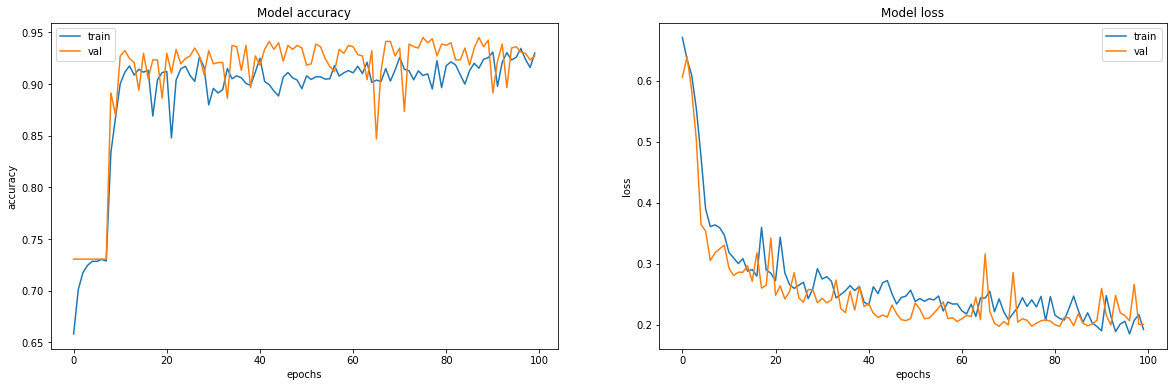

In [15]:
plot_history(basic_NN)

This brings some concerns about the model overfitting to the data. Let's check a differenet approach to examine it

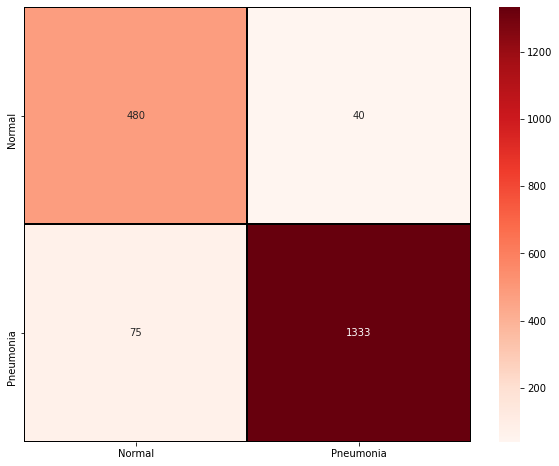

In [16]:
plot_confusion_matrix(model, flatten_test_data, flatten_test_labels)

So the model actually perform with accuaracy of 94% and by the confusion matrix we can see his efficency, eventhough in the graph we suspect the model is overfitting, it is shown that the model really gets the right answers on the test data.(the graph check the train vs validation data where the confusion matrix checks unrelated data that the model didn't met before, which is the test data)

### Convolutional Neural Network

#### Prepare data and set early parameters

In [8]:
# reshape the data to fit in to our CNN model
train_data = train_data.reshape(train_data.shape[0], 60, 100, 1)
valid_data = valid_data.reshape(valid_data.shape[0], 60, 100, 1)
test_data = test_data.reshape(test_data.shape[0], 60, 100, 1)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(3129, 60, 100, 1)
(783, 60, 100, 1)
(1928, 60, 100, 1)


### first attempt

In [9]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 4, activation="relu",padding='same', input_shape=(60,100,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size = 2, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 100, 32)       544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 25, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 12, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10752)             0

Now that we have a CNN model, let'w train it, but first we will add early stop parameters and learning decay, in order to improve out model's learning process and to save resources when the learning process is not improving any more:

In [10]:
LR_reduce = ReduceLROnPlateau(monitor='val_accuracy',
                           factor=.5,
                           patience=10,
                           min_lr=.000001,
                           verbose=0)

ES_monitor = EarlyStopping(monitor='val_loss', patience=20)

Now we can compile the model with 'adam' optimizer and a binary cross entropy loss function that fits  the kind of classification we are dealing with.

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
history = model.fit(train_data, train_labels,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    shuffle=True,
                    validation_data=(valid_data, valid_labels),
                    callbacks = [LR_reduce, ES_monitor])

Epoch 1/20
25/25 [==============================] - 29s 1s/step - loss: 0.5567 - accuracy: 0.7306 - val_loss: 0.3273 - val_accuracy: 0.8633
Epoch 2/20
25/25 [==============================] - 28s 1s/step - loss: 0.2768 - accuracy: 0.8865 - val_loss: 0.1780 - val_accuracy: 0.9310
Epoch 3/20
25/25 [==============================] - 29s 1s/step - loss: 0.1822 - accuracy: 0.9316 - val_loss: 0.1330 - val_accuracy: 0.9502
Epoch 4/20
25/25 [==============================] - 30s 1s/step - loss: 0.1665 - accuracy: 0.9428 - val_loss: 0.1453 - val_accuracy: 0.9476
Epoch 5/20
25/25 [==============================] - 30s 1s/step - loss: 0.1419 - accuracy: 0.9469 - val_loss: 0.1304 - val_accuracy: 0.9553
Epoch 6/20
25/25 [==============================] - 29s 1s/step - loss: 0.1298 - accuracy: 0.9537 - val_loss: 0.1170 - val_accuracy: 0.9566
Epoch 7/20
25/25 [==============================] - 30s 1s/step - loss: 0.1045 - accuracy: 0.9636 - val_loss: 0.1141 - val_accuracy: 0.9579
Epoch 8/20
25/25 [==

### Results

In [13]:
plot_results(model, test_data, test_labels)

61/61 [==============================] - 5s 82ms/step - loss: 0.1533 - accuracy: 0.9590

The final results are:

Test loss: 15%
Test accuracy: 95%


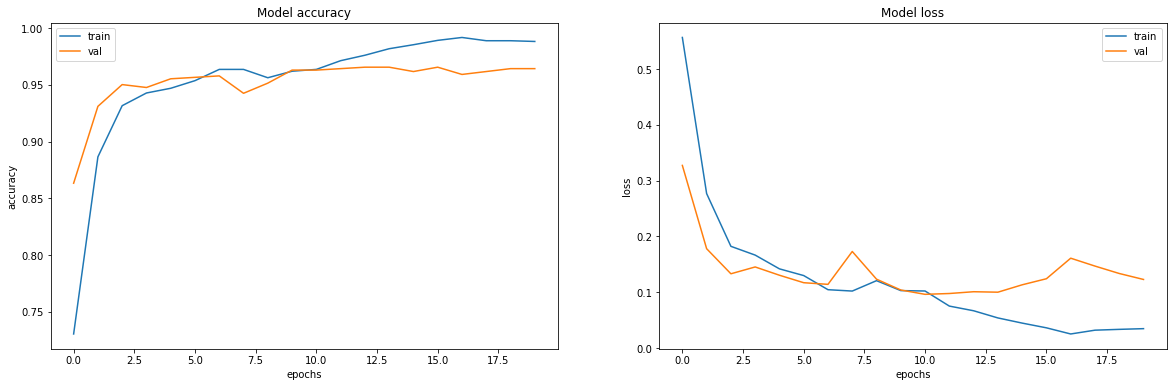

In [14]:
plot_history(history)

Seems like our model is overfitting the data. Eventhough the accuracy of the model is great with 95% efficacy.<br>Let's plot a confusion matrix to check the results

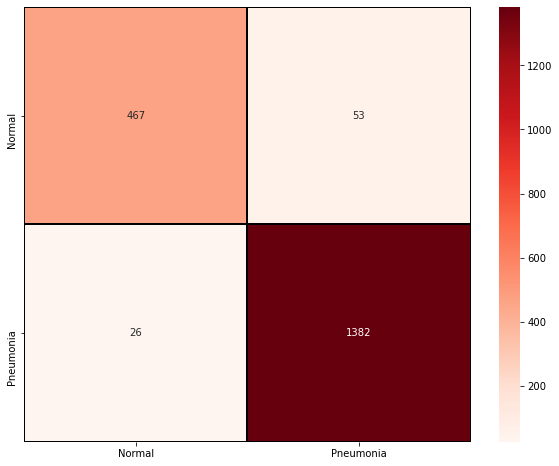

In [15]:
plot_confusion_matrix(model, test_data, test_labels)

### Second attempt

Let's try to double the conv layers, especially at the early process of the model, hopefully it will add some value to the learning abbilities of the model.

In [140]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 2, activation="relu",padding='same', input_shape=(60,100,1)))
model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
model.add(Conv2D(128, kernel_size = 4, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, kernel_size = 4, activation="relu", padding='same'))
model.add(Conv2D(256, kernel_size = 5, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 60, 100, 32)       160       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 60, 100, 64)       18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 50, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 50, 64)        36928     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 30, 50, 128)       131200    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 10, 16, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 10, 16, 128)      

In [141]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [143]:
history = model.fit(train_data, train_labels,
                    batch_size = 64,
                    epochs=10,
                    verbose=1,
                    shuffle=True,
                    validation_data=(valid_data, valid_labels),
                    callbacks = [LR_reduce, ES_monitor])

Epoch 1/10
49/49 [==============================] - 163s 3s/step - loss: 0.6155 - accuracy: 0.7303 - val_loss: 0.5791 - val_accuracy: 0.7305
Epoch 2/10
49/49 [==============================] - 174s 4s/step - loss: 0.5625 - accuracy: 0.7299 - val_loss: 0.5127 - val_accuracy: 0.7305
Epoch 3/10
49/49 [==============================] - 164s 3s/step - loss: 0.5199 - accuracy: 0.7379 - val_loss: 0.4085 - val_accuracy: 0.7688
Epoch 4/10
49/49 [==============================] - 153s 3s/step - loss: 0.3154 - accuracy: 0.8645 - val_loss: 0.2990 - val_accuracy: 0.8416
Epoch 5/10
49/49 [==============================] - 153s 3s/step - loss: 0.2247 - accuracy: 0.9179 - val_loss: 0.1774 - val_accuracy: 0.9400
Epoch 6/10
49/49 [==============================] - 152s 3s/step - loss: 0.1522 - accuracy: 0.9460 - val_loss: 0.1653 - val_accuracy: 0.9387
Epoch 7/10
49/49 [==============================] - 151s 3s/step - loss: 0.1408 - accuracy: 0.9492 - val_loss: 0.1531 - val_accuracy: 0.9387
Epoch 8/10
49

### Results

In [144]:
plot_results(model, test_data, test_labels)

61/61 [==============================] - 20s 323ms/step - loss: 0.1266 - accuracy: 0.9559

The final results are:

Test loss: 12%
Test accuracy: 95%


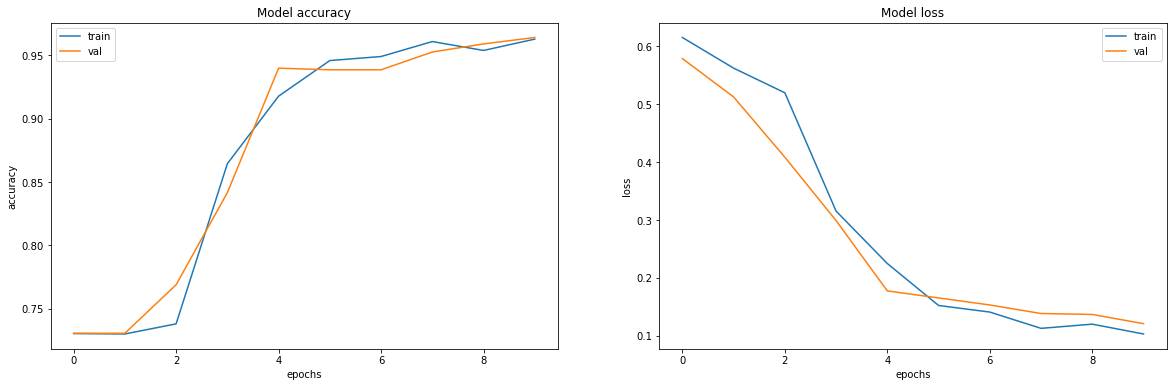

In [145]:
plot_history(history)

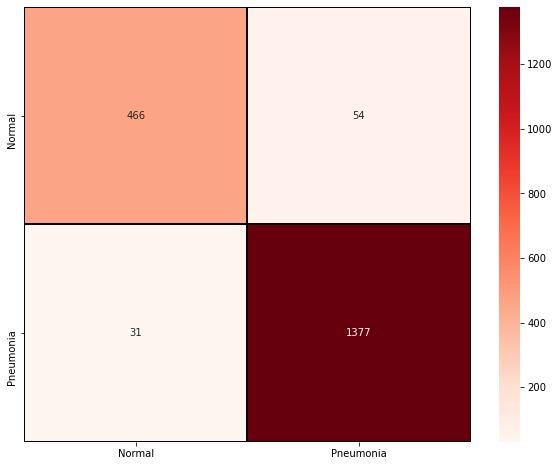

In [146]:
plot_confusion_matrix(model, test_data, test_labels)

The results are still great but didn't improve compare to the first attempt nor to the basic neural network. It's time to pick a different approach.

## SHAP testing

#### explain of this method 
games-theory method which in 2017 some guy implement it as an algorithm.<br>The method breakdown the neural network's features and let us see the "brain" behind the scenes. The CNN tells us WHAT is every image, and the shap method tells us WHY:
## ##add citation from github

In this part we will take the wrong prediction of the CNN models and try to understand where the models fall short:

#### Functions to test WRONG predictions

In [71]:
NUM_OF_TOP_MISTAKES = 10

# calculate the wrong predictions, distribution of answers by the model, top wrong predictions images
def calc_SHAP_mistakes_values(model, testing_data, testing_labels):
    
    pred = model.predict(testing_data)

    Y_pred_classes = np.argmax(pred,axis = 1) 
    Y_true = np.argmax(testing_labels,axis = 1)

    errors = (Y_pred_classes - Y_true != 0)

    wrong_pred_labels = Y_pred_classes[errors]
    wrong_pred_distribution = pred[errors]
    true_labels = Y_true[errors]
    wrong_images = testing_data[errors]


    Y_pred_errors_prob = np.max(wrong_pred_distribution, axis = 1)
    true_prob_errors = np.diagonal(np.take(wrong_pred_distribution, true_labels, axis=1))
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    top_mistakes = sorted_dela_errors[-NUM_OF_TOP_MISTAKES:]
    
    return top_mistakes, wrong_images, wrong_pred_labels, true_labels, wrong_pred_distribution


# plot the wrong predictions
def plot_mistakes(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            
            if pred_errors[error] == 1:
                prediction = "Pneumonia"
            else:
                prediction = "Normal"
                
            if obs_errors[error] == 1:
                original = "Pneumonia"
            else:
                original = "Normal"
                
            ax[row,col].imshow((img_errors[error]).reshape((60,100)), cmap="gray")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(prediction,original))
            n += 1
    plt.show()
    
    
# plot the SHAP values of images with the answers probability    
def plot_SHAP_values(model, testing_data, wrong_pred, wrong_pred_index):

    explainer = shap.DeepExplainer(model, (testing_data[0:100])) # amount of images to create background 
    
    conditions = ["Normal", "Pneumonia"]

    for i in wrong_pred_index[:5]:     #Check out the 5 data that the model has mistakenly predicted.
    
    #Calculates the SHAP value.
        shap_values = explainer.shap_values(wrong_pred[[i]])
    
        if wrong_pred_labels[i] == 1:
            prediction = "Pneumonia"
        else:
            prediction = "Normal"
    
        if true_labels[i] == 1:
            original = "Pneumonia"
        else:
            original = "Normal"
        
        
        #calculate the answers probability
        index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(pred_dist[i][num]) for num, x in enumerate(conditions)]).reshape(1,2)
        print("Predicted label :{}\nTrue label :{}".format(prediction,original))
    
        #Displays the results.
        shap.image_plot(shap_values, wrong_pred[[i]] ,index_names ,show=False)
#        plt.figure(figsize=(15,8))
        plt.show()

### First attempt

#### Testing SHAP values of wrong predictions by our model

In [61]:
# load the varaiables
top_mistakes, wrong_images, wrong_pred_labels, true_labels, pred_dist = calc_SHAP_mistakes_values(model, test_data, test_labels)

Let's plot first the 10 top mistakes to see it in our own eyes

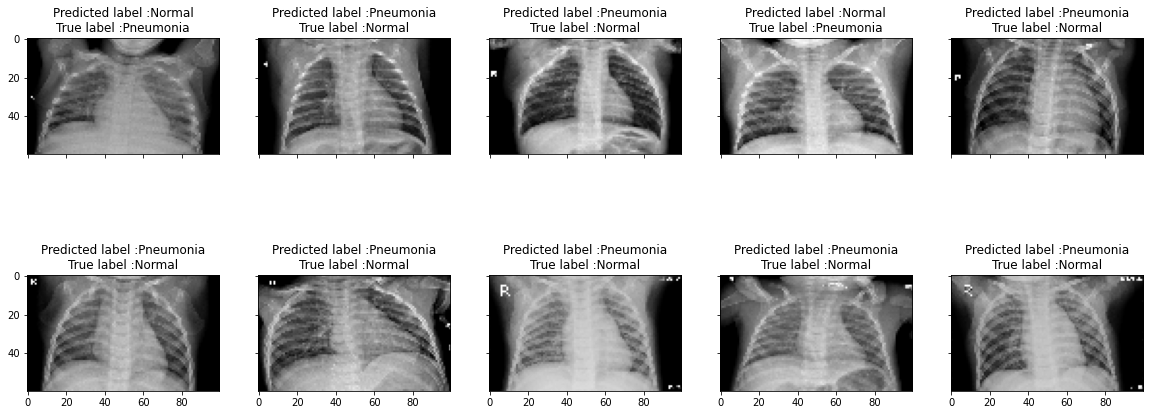

In [62]:
plot_mistakes(top_mistakes, wrong_images, wrong_pred_labels, true_labels)

Now it's time to let the SHAP method do his magic:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

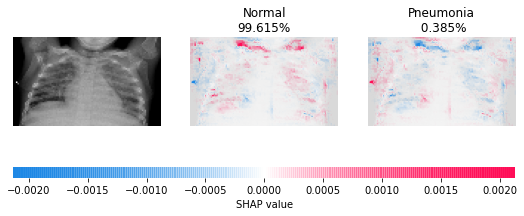

Predicted label :Pneumonia
True label :Normal


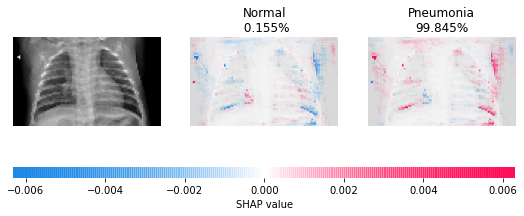

Predicted label :Pneumonia
True label :Normal


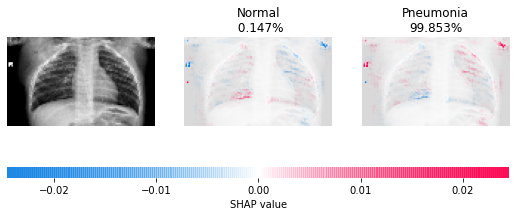

Predicted label :Normal
True label :Pneumonia


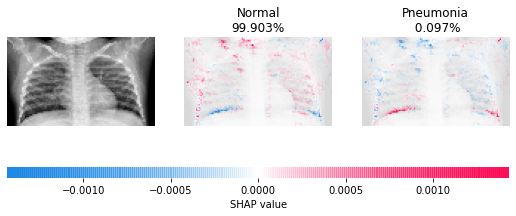

Predicted label :Pneumonia
True label :Normal


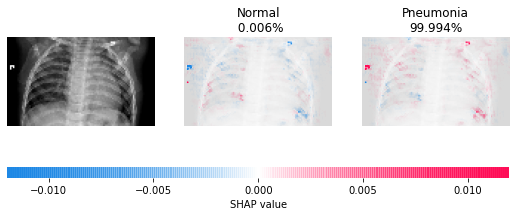

Wall time: 24.1 s


In [65]:
plot_SHAP_values(model, test_data, wrong_images, top_mistakes)

In [152]:
# TODO
# Elaborate on what we see in the images with the SHAP values above

### Second attempt

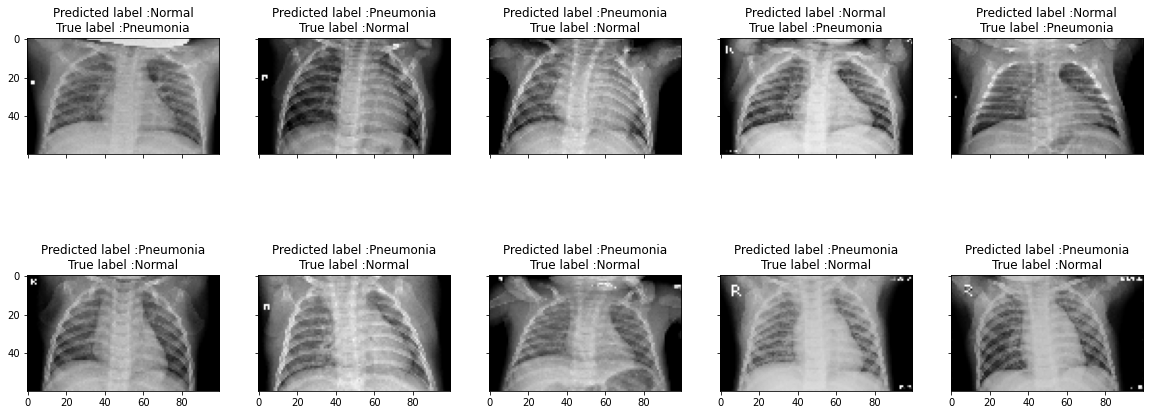

In [147]:
# load the varaiables
top_mistakes, wrong_images, wrong_pred_labels, true_labels, pred_dist = calc_SHAP_mistakes_values(model, test_data, test_labels)

plot_mistakes(top_mistakes, wrong_images, wrong_pred_labels, true_labels)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

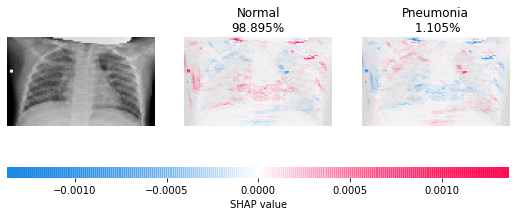

Predicted label :Pneumonia
True label :Normal


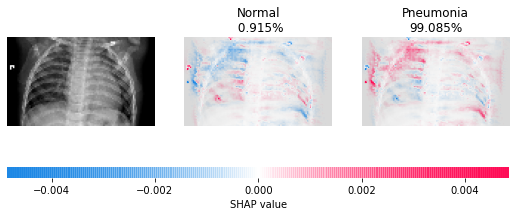

Predicted label :Pneumonia
True label :Normal


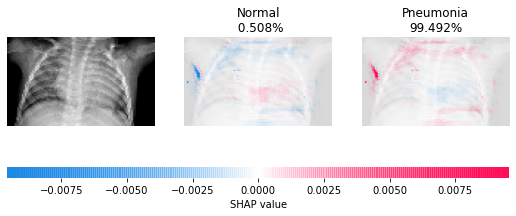

Predicted label :Normal
True label :Pneumonia


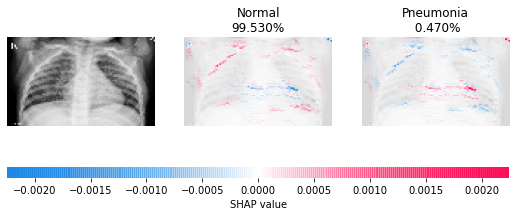

Predicted label :Normal
True label :Pneumonia


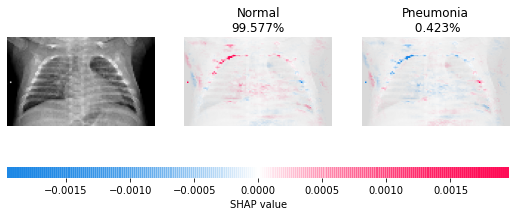

In [148]:
plot_SHAP_values(model, test_data, wrong_images, top_mistakes)

In [154]:
# Did in this next part function for personal use, 
# mainly to observe how correct predictions looks with their SHAP values

### Function to test CORRECT predictions

In [117]:
# calculate the wrong predictions, distribution of answers by the model, top wrong predictions images
def calc_SHAP_correct_values(model, testing_data, testing_labels):
    
    pred = model.predict(testing_data)

    Y_pred_classes = np.argmax(pred,axis = 1) 
    Y_true = np.argmax(testing_labels,axis = 1)

    correct = (Y_pred_classes - Y_true != 1)

    correct_pred_labels = Y_pred_classes[correct]
    correct_pred_distribution = pred[correct]
#    true_labels = Y_true[errors]
    correct_images = testing_data[correct]


    Y_pred_errors_prob = np.max(correct_pred_distribution, axis = 1)
    true_prob_errors = np.diagonal(np.take(correct_pred_distribution, correct_pred_labels, axis=1))
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    top_mistakes = sorted_dela_errors[-NUM_OF_TOP_MISTAKES:]
    
    return top_mistakes, correct_images, correct_pred_labels, correct_pred_labels, correct_pred_distribution



# plot the wrong predictions
def plot_correct(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            
            if pred_errors[error] == 1:
                prediction = "Pneumonia"
            else:
                prediction = "Normal"
                
            if obs_errors[error] == 1:
                original = "Pneumonia"
            else:
                original = "Normal"
                
            ax[row,col].imshow((img_errors[error]).reshape((60,100)), cmap="gray")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(prediction,original))
            n += 1
    plt.show()
    
    
# plot the SHAP values of images with the answers probability    
def plot_SHAP_correct_values(model, testing_data, correct_pred, correct_pred_index):

    explainer = shap.DeepExplainer(model, (testing_data[0:100])) # amount of images to create background 
    
    conditions = ["Normal", "Pneumonia"]

    for i in correct_pred_index[:3]:     #Check out the 5 data that the model has correct predicted.
    
    #Calculates the SHAP value.
        shap_values = explainer.shap_values(correct_pred[[i]])
    
        if correct_pred_labels[i] == 1:
            prediction = "Pneumonia"
        else:
            prediction = "Normal"
    
        if correct_labels[i] == 1:
            original = "Pneumonia"
        else:
            original = "Normal"
        
        
        #calculate the answers probability
        index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(correct_pred_dist[i][num]) for num, x in enumerate(conditions)]).reshape(1,2)
        print("Predicted label :{}\nTrue label :{}".format(prediction,original))
    
        #Displays the results.
        shap.image_plot(shap_values, correct_pred[[i]] ,index_names ,show=False)
        plt.show()

#### Testing SHAP values of correct predictions by our model

In [115]:
top_correct, correct_images, correct_pred_labels, correct_labels, correct_pred_dist = calc_SHAP_correct_values(model, test_data, test_labels)

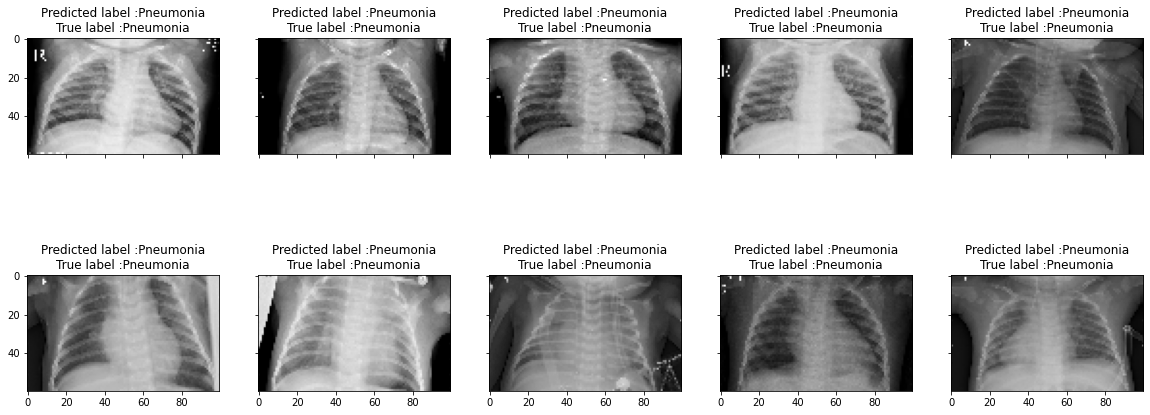

In [96]:
plot_correct(top_correct, correct_images, correct_pred_labels, correct_labels)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

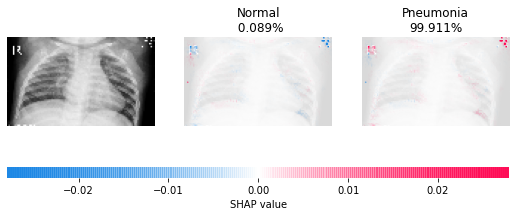

Predicted label :Pneumonia
True label :Pneumonia


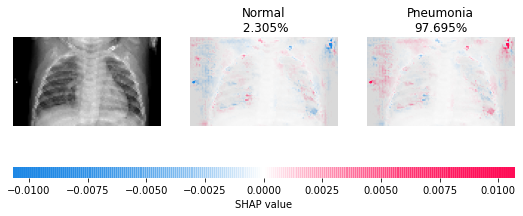

Predicted label :Pneumonia
True label :Pneumonia


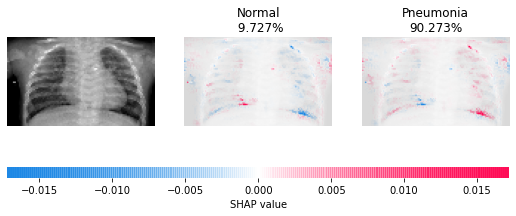

Wall time: 20 s


In [118]:
%%time
plot_SHAP_correct_values(model, test_data, correct_images, top_correct)

In [ ]:
## Elad's CNN - performed same as the rest of the models if not a bit worst, but took a full night to train.
# save it in case we will need some ideas..

In [97]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5,5),activation='relu', input_shape=(60,100,1)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(.25))

model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(.25))


#model.add(Conv2D(128, kernel_size=(3,3),activation='relu', kernel_regularizer=regularizers.l2(reg)))
#model.add(BatchNormalization(axis=-1,center=True,scale=False))
#model.add(Conv2D(256, kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(reg)))
#model.add(BatchNormalization(axis=-1,center=True,scale=False))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#model.add(Dropout(.25))

#model.add(Conv2D(128, kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(reg)))
#model.add(BatchNormalization(axis=-1,center=True,scale=False))
#model.add(Conv2D(256, kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(reg)))
#model.add(BatchNormalization(axis=-1,center=True,scale=False))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#model.add(Dropout(.25))

model.add(Flatten())
model.add(Dense(300,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))
model.add(Dense(200,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 56, 96, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 96, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 52, 92, 128)       102528    
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 92, 128)       512       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 26, 46, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 26, 46, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 44, 32)       